# PID Controller Tuning

## 1.Empirical Method

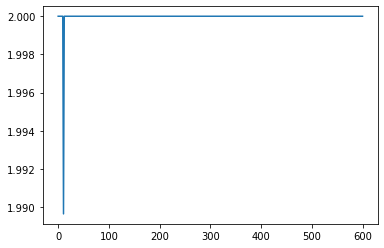

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def fopdt(t, K, tau, theta):
    return K*(1-np.exp((-(t-theta)/tau))*(t>theta))

t = np.linspace(0,600,400)

y= fopdt(t,2,.1,10)
plt.plot(t,y)

### PID reference implementation

In [18]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    #initialize stored data
    t_prev = -100
    P = 0
    I = 0
    D = 0
    S = 0 
    N = 5
    
    #initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, SP, PV = data
        else:
            t, SP, PV, TR = data
            I = TR - MV_bar - P - D
        # PID calculations
        P = Kp*(beta*SP-PV)
        I +=  Ki*(SP-PV)*(t-t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for antu-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored datat for nest iteration
        S += D*(t-t_prev) 
        t_prev = t

## 2.AMIGO Tuning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

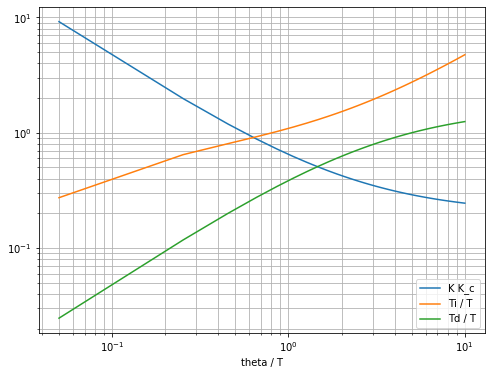

In [2]:
r = np.linspace(0.05, 10)
kr = 0.2 + 0.45/r
ir = r*(0.4*r + 0.8)/(r + 0.1)
dr = 0.5*r/(0.3*r + 1)
plt.figure(figsize=(8, 6))
plt.loglog(r, kr, r, ir, r, dr)
plt.legend(['K K_c', 'Ti / T', 'Td / T'])
plt.xlabel('theta / T')
plt.grid(True, which = 'both') # show both grid

## 3.Ziegler Nichols Tuning

Relay Tuning

In [4]:
def relay(SP, a=5):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        if PV > SP-a:
            MV=100
        else:
            MV = 0
        if PV > SP+a:
            MV = 100
        else:
            MV = MV_prev

### For graph no PID controller

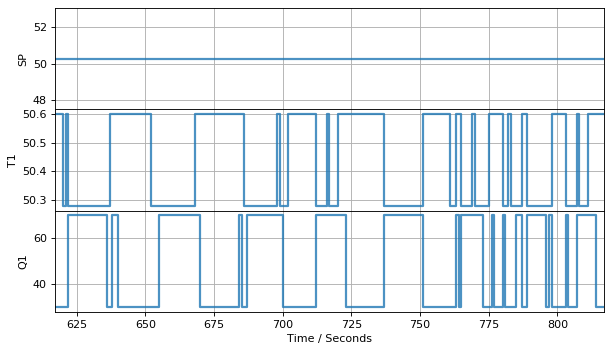

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

tfinal = 1200
MV_bar = 50
hMV = 20

with TCLab() as lab:
    h = Historian([('SP',lambda:SP), ('T1', lambda: lab.T1), ('Q1',lab.Q1)])
    p = Plotter(h, 200)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        if t < 600:
            SP = lab.T1
            MV = MV_bar
        else:
            MV = (MV_bar-hMV) if (lab.T1 > SP) else (MV_bar + hMV)
        lab.Q1(MV)
        p.update(t) # update information display

In [19]:
# Hyperparameter
Pu = 140
h = 20
a =1.5
Ku = 4*h/a/3.14


In [20]:
Ku

16.985138004246284

In [21]:
# Hyperparameter
Kp = Ku/2
Ti = Pu/2
Td = Pu/8

Ki = Kp/Ti
Kd = Kp*Td
print('Kp = {:.2f} Ki = {:.2f} Kd = {:.2f}'.format(Kp, Ki, Kd))

Kp = 8.49 Ki = 0.12 Kd = 148.62


### For graph with PID controller


In [22]:
%matplotlib inline
from tclab import setup, Historian, Plotter, clock

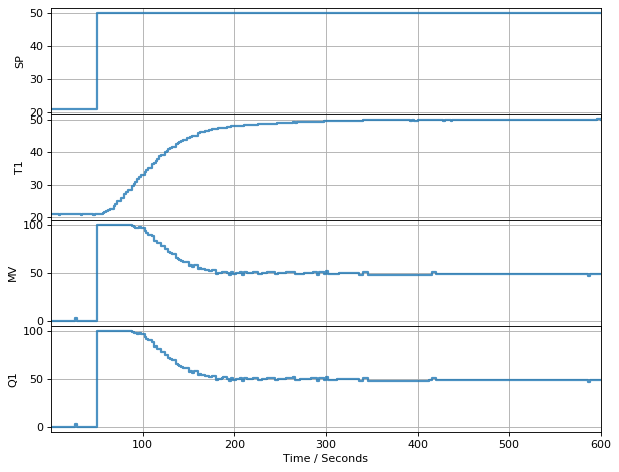

TCLab Model disconnected successfully.


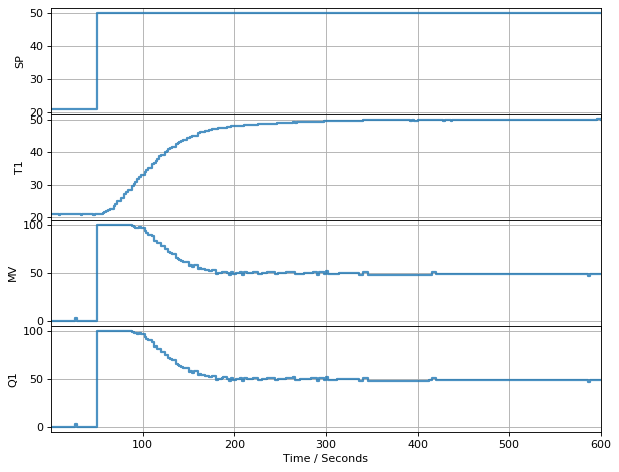

In [23]:
TCLab = setup(connected = False, speedup=10)

controller = PID(Kp, Ki, Kd, beta=1, gamma=1) # create pid control
controller.send(None) # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda:SP), ('T1', lambda:lab.T1), ('MV', lambda:MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50 # get setpoint
        PV = lab.T1
        MV = controller.send([t, SP, PV]) # compute manipulated variable
        lab.Q1(MV)
        p.update(t)

### PID Cotroller with an additional filter used for a more robust implementation of derivative action. 

In [25]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    t_prev = -100
    P = 0
    I = 0
    D = 0
    S = 0
    N = 10
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, SP, PV = data
        else:
            t, SP, PV, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

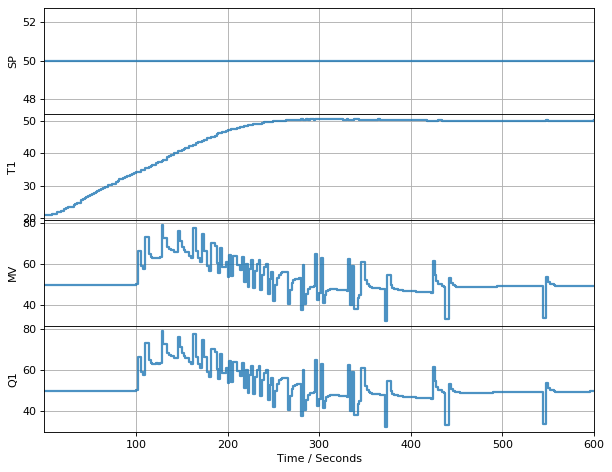

TCLab Model disconnected successfully.


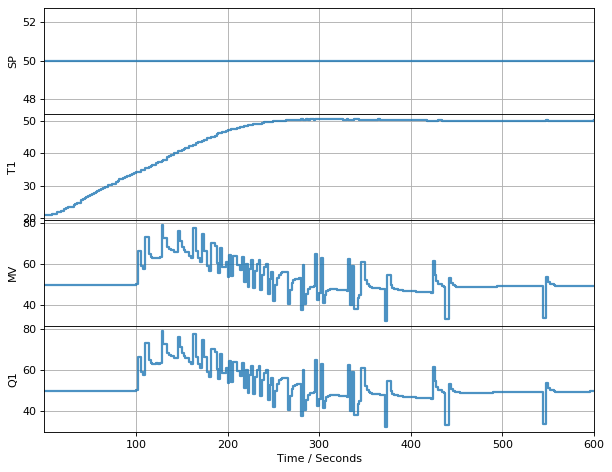

In [27]:
# run lab
# Hyperparameter
Pu = 140
h = 20
a =1.5
Ku = 4*h/a/3.14
Kp = Ku/2
Ti = Pu/2
Td = Pu/8

Ki = Kp/Ti
Kd = Kp*Td
print('Kp = {:.2f} Ki = {:.2f} Kd = {:.2f}'.format(Kp, Ki, Kd))

%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(Kp, Ki, Kd, beta=0) # create pid control
controller.send(None) # initialize

tfinal = 600
SP = 50

with TCLab() as lab:
    sources = [('SP', lambda:SP), ('T1', lambda: lab.T1), ('MV', lambda:MV), ('Q1', lab.Q1)]
    h = Historian(sources)
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1
        MV = controller.send([t, SP, PV, lab.U1]) # for bumpless transfer
        if t < 100:
            MV = 50
        lab.U1 = MV # apply
        p.update(t) # update information display